In [1]:
# 必要包安装

!pip install -i http://didiyum.sys.xiaojukeji.com/didiyum/pip/simple/ --trusted-host didiyum.sys.xiaojukeji.com pycausalimpact
!pip install -i http://didiyum.sys.xiaojukeji.com/didiyum/pip/simple/ --trusted-host didiyum.sys.xiaojukeji.com protobuf

Looking in indexes: http://didiyum.sys.xiaojukeji.com/didiyum/pip/simple/
     |████████████████████████████████| 9.5 MB 74.3 MB/s eta 0:00:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
You should consider upgrading via the '/home/xiaoju/jupyterlab/venv/bin/python3 -m pip install --upgrade pip' command.
E0808 18:46:59.908913774   14513 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1659955619.908833935","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1659955619.908830494","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
Looking in indexes: http://didiyum.sys.xiaojukeji.com/didiyum/pip/simple/
You should consider upgrading via the '/h

In [2]:
#pip uninstall -i http://didiyum.sys.xiaojukeji.com/didiyum/pip/simple/ --trusted-host didiyum.sys.xiaojukeji.com pycausalimpact

E0728 17:34:18.541618302    3991 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1659000858.541514099","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1659000858.541501856","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":957,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}

Usage:   
  /home/xiaoju/jupyterlab/venv/bin/python3 -m pip uninstall [options] <package> ...
  /home/xiaoju/jupyterlab/venv/bin/python3 -m pip uninstall [options] -r <requirements file> ...

no such option: -i
Note: you may need to restart the kernel to use updated packages.


In [3]:
import  numpy as np
import statsmodels
from causalimpact import CausalImpact
##import statsmodels.api as sm
import  pandas as pd 
from pyhive import hive
import os

import warnings
warnings.filterwarnings('ignore')

###  1、获取数据

In [2]:
conn = hive.connect(
        host=os.environ['PYHIVE_HOST'], 
        port=os.environ['PYHIVE_PORT'],
        username=os.environ['JUPYTER_HADOOP_USER'],
        password=os.environ['HADOOP_USER_PASSWORD'],
        auth='LDAP',
        configuration={'mapreduce.job.queuename': os.environ['JUPYTER_HADOOP_QUEUE'],
                       'hive.resultset.use.unique.column.names':'false'})

In [3]:
sql="""
   with
order_info as 
(
    select  order_detail.dt
            ,order_detail.start_city_id
            ,start_city_name
            ,order_detail.dest_city_id
            ,dest_city_name
            ,order_detail.busi_type
            ,holiday_detail.is_weekend
            ,holiday_detail.is_holiday
            ,exp_data.treat_label
            ,count(DISTINCT order_detail.order_id) as finish_order_num
            ,nvl(sum(gmv), 0) as gmv
            ,nvl(sum(b_bu), 0) as b_bu
            ,nvl(sum(c_bu), 0) as c_bu
            ,nvl(sum(b_bu), 0) + nvl(sum(c_bu), 0) as total_bu
    from    (
        select  dt
                ,order_id
                ,start_city_name
                ,start_city_id
                ,dest_city_id
                ,dest_city_name
                ,is_td_finish_flag
                ,case   when busi_type = 0 then '跨城'
                        when busi_type in (1, 2) then '市内'
                        else '其他'
                 end as busi_type
                ,passenger_num as passenger_num
                ,case   when is_carp_flag = 0 then '独享价'
                        when busi_type = 0 and is_carp_flag = 1 then "愿拼价"
                        when busi_type in (1, 2) and is_carp_flag = 1 and is_td_carp_succ_flag = 1 then '拼成价'
                        when busi_type in (1, 2) and is_carp_flag = 1 and is_td_carp_succ_flag = 0 then '愿拼价'
                        else null
                 end price_type
                ,cast(round(est_dis / 10000, 0) * 10 as int) as distance_type
                ,case   when hour(consult_time) between 7 and 9 then '早高峰'
                        when hour(consult_time) between 17 and 19 then '晚高峰'
                        else '非高峰'
                 end as peak
        from    dd_cdm.dwd_btls_trd_order_base_di
        where   dt between '2021-09-13'
          and   '2022-07-03'
          and   coalesce(is_test_flag, 0) = 0
          and   is_td_finish_flag = 1
          and   busi_type in (1, 2, 0)
        group by dt, order_id, start_city_name, start_city_id, dest_city_id, dest_city_name, is_td_finish_flag, case when busi_type = 0 then '跨城' when busi_type in (1, 2) then '市内' else '其他' end, passenger_num, case when is_carp_flag = 0 then '独享价' when busi_type = 0 and is_carp_flag = 1 then "愿拼价" when busi_type in (1, 2) and is_carp_flag = 1 and is_td_carp_succ_flag = 1 then '拼成价' when busi_type in (1, 2) and is_carp_flag = 1 and is_td_carp_succ_flag = 0 then '愿拼价' else null end, cast(round(est_dis / 10000, 0) * 10 as int), case when hour(consult_time) between 7 and 9 then '早高峰' when hour(consult_time) between 17 and 19 then '晚高峰' else '非高峰' end, is_td_finish_flag, order_id
    ) order_detail
    left join (
        select  calendar_date
                ,case   when is_work_day = 0 then 1
                        else 0
                 end as is_weekend
                ,case   when formal_holiday_type = "法定假日" then 1
                        else 0
                 end as is_holiday
        from    whole_dw.dim_date
        where   dt = '2022-07-03'
          and   calendar_date between '2021-09-13'
          and   '2022-07-03'
        group by calendar_date, case when is_work_day = 0 then 1 else 0 end, case when formal_holiday_type = "法定假日" then 1 else 0 end
    ) holiday_detail
    on      order_detail.dt = holiday_detail.calendar_date
    left join (
        select  start_city_id
                ,dest_city_id
                ,busi_type
                ,passenger_num
                ,price_type
                ,distance_type
                ,peak
                ,treat_label
        from    beatles_bi_dm.treat_price_split_dim_2022_07
    ) exp_data
    on      order_detail.start_city_id = exp_data.start_city_id
      and   order_detail.dest_city_id = exp_data.dest_city_id
      and   order_detail.busi_type = exp_data.busi_type
      and   order_detail.passenger_num = exp_data.passenger_num
      and   order_detail.price_type = exp_data.price_type
      and   order_detail.distance_type = exp_data.distance_type
      and   order_detail.peak = exp_data.peak
    left join (
        select  order_id
                ,sum(total) / 100 as gmv
        from    beatles_dwd.dwd_order_gmv_d
        where   concat_ws('-', year, month, day) between '2021-09-13'
          and   '2022-07-03'
        group by order_id
    ) gmv_detail
    on      order_detail.order_id = gmv_detail.order_id
    left join (
        select  order_id
                ,sum(b_shibu) as b_bu
                ,sum(c_shibu) as c_bu
        from    beatles_bi_dm.hjl_subsidy_detail
        where   concat_ws('-', year, month, day) between '2021-09-13'
          and   '2022-07-03'
        group by order_id
    ) order_amt
    on      order_detail.order_id = order_amt.order_id
    group by order_detail.dt, order_detail.start_city_id, start_city_name, order_detail.dest_city_id, dest_city_name, order_detail.busi_type, holiday_detail.is_weekend, holiday_detail.is_holiday, exp_data.treat_label
)
,city_yiqing as 
(
    select  covid_1.local_new_dt as dt
            ,covid_1.city_id
            ,covid_1.city_name
            ,covid_1.pro_name
            ,covid_1.local_city_added
            ,covid_2.local_pro_added
    from    (
        select  local_new_dt
                ,city_id
                ,city_name_match as city_name
                ,pro_id
                ,pro_name_match as pro_name
                ,sum(local_added) as local_city_added
        from    ht_bi.covid_city_data
        where   pt = '2022-07-03'
          and   local_new_dt between '2021-09-13'
          and   '2022-07-03'
        group by local_new_dt, city_id, city_name_match, pro_id, pro_name_match
    ) as covid_1
    left join (
        select  local_new_dt
                ,pro_id
                ,pro_name_match
                ,sum(local_added) as local_pro_added
        from    ht_bi.covid_city_data
        where   pt = '2022-07-03'
          and   local_new_dt between '2021-09-13'
          and   '2022-07-03'
        group by local_new_dt, pro_id, pro_name_match
    ) as covid_2
    on      covid_1.local_new_dt = covid_2.local_new_dt
      and   covid_1.pro_id = covid_2.pro_id
)
,city_info as 
(
    select  distinct city_id
            ,pro_name
    from    whole_dw.dim_city
    where   dt = '2022-07-03'
      and   city_id between 1
      and   1000
)
select  order_info.dt
        ,order_info.start_city_id as start_city_id
        ,order_info.start_city_name as start_city_name
        ,city_info.pro_name as start_pro_name
        ,order_info.dest_city_id as dest_city_id
        ,order_info.dest_city_name as dest_city_name
        ,order_info.busi_type as busi_type
        ,order_info.is_weekend as is_weekend
        ,order_info.is_holiday as is_holiday
        ,case   when busi_type = '市内' and order_info.start_city_id in (17, 6, 173, 50, 51, 118, 286, 53, 227, 231, 289) then '对照组'
                when busi_type = '跨城' and order_info.start_city_id in (17, 6, 32, 35, 142, 173, 286, 34, 289, 231, 143, 232, 50, 230, 227, 236) then '对照组' else order_info.treat_label
         end as exp_group
        ,coalesce(order_info.finish_order_num, 0) as `完单`
        ,coalesce(order_info.gmv, 0) as gmv
        ,coalesce(order_info.b_bu, 0) as b_bu
        ,coalesce(order_info.c_bu, 0) as c_bu
        ,coalesce(order_info.total_bu, 0) as total_bu
        ,coalesce(city_yiqing.local_city_added, 0) as start_local_city_added
        ,coalesce(city_yiqing.local_pro_added, 0) as start_local_pro_added
from    order_info
left join city_yiqing
on      order_info.start_city_id = city_yiqing.city_id
  and   order_info.dt = city_yiqing.dt
left join city_info
on      city_info.city_id = order_info.start_city_id

"""

In [4]:
data = pd.read_sql_query(sql,conn)

In [5]:
print(len(data))

566022


[autoreload of causalimpact failed: Traceback (most recent call last):
  File "/home/xiaoju/jupyterlab/venv/lib64/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/xiaoju/jupyterlab/venv/lib64/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib64/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/xiaoju/jupyterlab/venv/lib64/python3.6/site-packages/causalimpact/__init__.py", line 26, in <module>
    from causalimpact.analysis import CausalImpact  # noqa
  File "/home/xiaoju

In [ ]:
data.to_csv(r'./data/data_city.csv')

### 2、数据清洗，清洗完结果可直接进模型，依靠分组标签进行划分

In [24]:
data=pd.read_csv(r'data_city.csv')
data=data.drop(["Unnamed: 0"],axis=1)
data

,dt,start_city_id,start_city_name,start_pro_name,dest_city_id,dest_city_name,busi_type,is_weekend,is_holiday,exp_group,完单,gmv,毛利,b_bu,c_bu,total_bu,start_local_city_added,start_local_pro_added
0,2021-11-23,1,北京市,北京,7,天津市,跨城,0,0,NaN,17,1482.7,148.0,52.00,16.00,68.00,0,0
1,2021-11-23,1,北京市,北京,46,廊坊市,跨城,0,0,NaN,240,12885.5,1266.2,1048.00,162.10,1210.10,0,0
2,2021-11-23,1,北京市,北京,1,北京市,市内,0,0,NaN,5769,285033.1,28188.8,27521.00,6410.18,33931.18,0,0
3,2021-11-23,1,北京市,北京,78,张家口市,跨城,0,0,NaN,1,87.7,8.8,10.00,0.00,10.00,0,0
4,2021-11-24,1,北京市,北京,1,北京市,市内,0,0,NaN,6059,300338.2,29681.8,30587.46,6679.12,37266.58,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
566017,2022-07-01,372,杨凌示范区,陕西省,10,西安市,跨城,0,0,NaN,3,216.7,21.6,26.00,5.00,31.00,0,0
566018,2022-07-02,372,杨凌示范区,陕西省,116,咸阳市,跨城,1,0,NaN,5,249.8,24.9,20.00,0.00,20.00,0,0
566019,2022-07-02,372,杨凌示范区,陕西省,10,西安市,跨城,1,0,NaN,7,652.1,65.4,6.00,0.00,6.00,0,0
566020,2022-07-03,372,杨凌示范区,陕西省,116,咸阳市,跨城,1,0,NaN,5,304.8,30.5,44.00,0.00,44.00,0,0


In [18]:

## 数据清洗，按照标签的完整数据清洗，清洗结果可直接进入模型
## dt为索引，第一列为响应变量，其他为协变量
def data_clear(data,busi_type,treat_label,contrl_province,response_feature):
    
    ## 对照组已完全设定好，contrl_province实际为‘对照组’，不需要设定省份了
    
    '''
##  响应变量和协变量分开两部分处理
treat_data_y    ## 响应变量
treat_data_x   ## 补贴，疫情，极端天气等等

control_data_y    ## 对照组对应的相应变量
control_data_x    ## 对照组疫情，极端天气等等
'''
    
    ### 实验组数据处理
    treat_data=data.loc[(data['exp_group']==treat_label)&(data['busi_type']==busi_type)]

    treat_data_y=pd.pivot_table(treat_data,index='dt',values=response_feature,aggfunc=np.sum)

    treat_data_x=pd.pivot_table(treat_data,index=['dt','start_city_name'],
                                values=['完单','total_bu','start_local_pro_added'],
                                aggfunc={'完单':np.sum,'total_bu':np.sum,'start_local_pro_added':np.mean}).reset_index()

    ### 补贴，疫情病例数处理
    treat_data_x=pd.pivot_table(treat_data_x,index='dt',
                               values=['完单','total_bu','start_local_pro_added'],
                                aggfunc=np.sum)

    treat_data_x['total_bu_per_order']=treat_data_x['total_bu']/treat_data_x['完单']

    treat_data=pd.concat([treat_data_y,treat_data_x[['total_bu_per_order','start_local_pro_added']]],axis=1)


    ## 对照组数据处理
    control_data=data.loc[(data['exp_group'].isin(contrl_province))&(data['busi_type']==busi_type)]

    control_data_y=pd.pivot_table(control_data,index='dt',values=response_feature,aggfunc=np.sum)

    control_data_x=pd.pivot_table(control_data,index=['dt','start_city_name'],
                                values='start_local_pro_added',
                                aggfunc=np.mean).reset_index()

    control_data_x=pd.pivot_table(control_data_x,index='dt',
                               values='start_local_pro_added',
                                aggfunc=np.sum)

    control_data=pd.concat([control_data_y,control_data_x],axis=1)
    control_data.columns=['完单_control','yiqing']

    data_re=pd.concat([treat_data,control_data],axis=1)
    data_re['dt']=pd.to_datetime(data_re.index)
    data_re.set_index(data_re['dt'],inplace=True)
    data_re.drop(columns='dt',inplace=True)

    return data_re

### 3、模型训练，只负责模型的训练，承接第2步数据

In [19]:
##  模型训练
def CI(data_clear,time_point_1,time_point_2):
    
    ci = CausalImpact(data_clear,
                      [pd.to_datetime(np.min(data_clear.index.values)), pd.to_datetime(time_point_1)],
                      [pd.to_datetime(time_point_2),pd.to_datetime(np.max(data_clear.index.values))],
                      #nseasons=[{'period':7}],
                      alpha=0.1,
                     )
                        
    
    #print(ci.summary(output='summary'))
    #print(ci.summary(output='report'))
    ci.plot()
    
    infer = ci.inferences
    
    return infer

市内 - 涨价 - 完单    评估


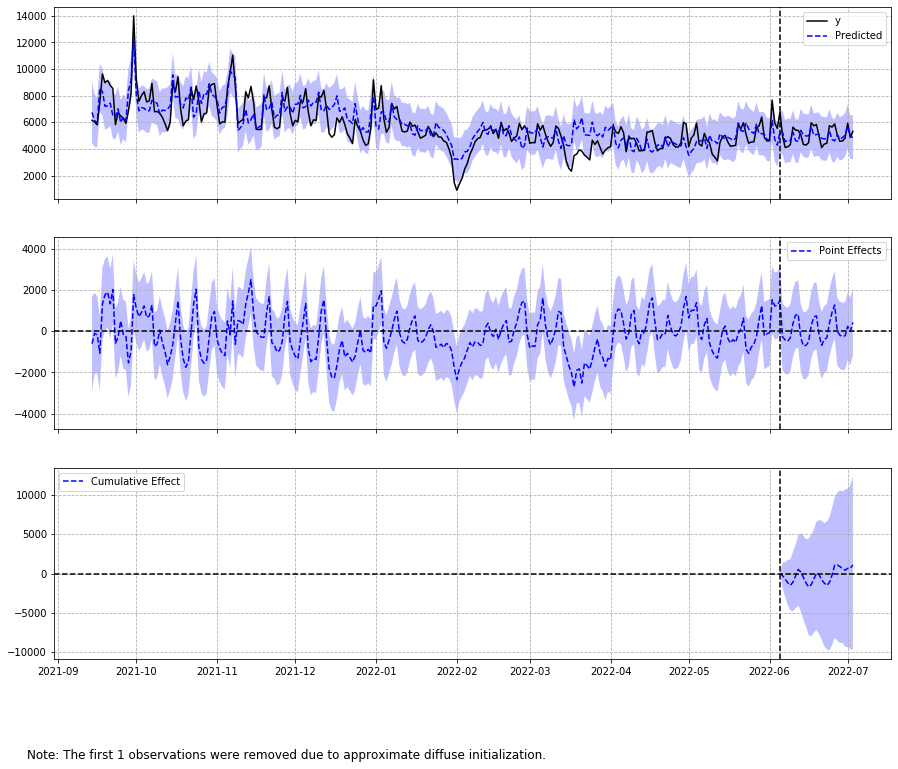

In [20]:
# 对照期结束时间
time_point_1='2022-06-05'
## AA检验期开始时间
time_point_2='2022-06-06'

busi_type='市内'
treat_label='涨价'
contrl_province=['对照组']
response_feature='完单'    ##  gmv，毛利
##covariate_list  暂不自定义筛选，先手动筛选看效果

## AA对照测试/评估逻辑与AA对照一致
print(busi_type,'-',treat_label,'-',response_feature,'   评估')
data_clear_1=data_clear(data,busi_type=busi_type,treat_label=treat_label,contrl_province=contrl_province,response_feature=response_feature)
ci=CI(data_clear_1,time_point_1,time_point_2)

In [21]:
data_clear_1.columns
data_clear_1.replace(to_replace=[None],value='None',inplace=True)
data_clear_1

,完单,total_bu_per_order,start_local_pro_added,完单_control,yiqing
dt,,,,,
2021-09-13,6657,2.904664,0,13561,0
2021-09-14,6151,4.461909,0,12302,0
2021-09-15,6024,3.209562,0,12306,0
2021-09-16,5811,2.638909,0,12470,0
2021-09-17,7518,10.029330,0,15317,0
...,...,...,...,...,...
2022-06-29,4599,1.672861,24,10086,0
2022-06-30,4819,2.162059,0,10205,0
2022-07-01,5937,2.689823,0,12302,0


### 4、结果的输出  AA校验/结果评估

市内 - 涨价 - 完单    评估


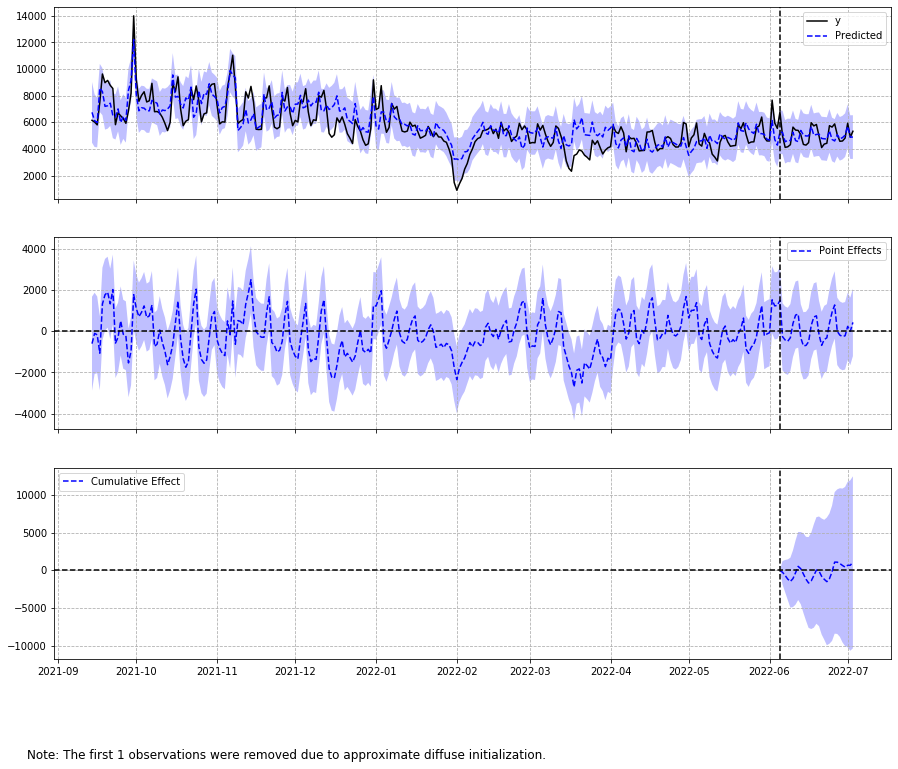

In [13]:
# 对照期结束时间
time_point_1='2022-06-05'
## AA检验期开始时间
time_point_2='2022-06-06'

busi_type='市内'
treat_label='涨价'
contrl_province=['对照组']
response_feature='完单'    ##  gmv，毛利
##covariate_list  暂不自定义筛选，先手动筛选看效果

## AA对照测试/评估逻辑与AA对照一致
print(busi_type,'-',treat_label,'-',response_feature,'   评估')
data_clear_1=data_clear(data,busi_type=busi_type,treat_label=treat_label,contrl_province=contrl_province,response_feature=response_feature)
ci=CI(data_clear_1,time_point_1,time_point_2)

市内 - 降价 - 完单    评估
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1301.57            36444.0
Prediction (s.d.)         1310.24 (63.41)    36686.79 (1775.36)
90% CI                    [1202.21, 1410.79] [33661.77, 39502.17]

Absolute effect (s.d.)    -8.67 (63.41)      -242.79 (1775.36)
90% CI                    [-109.22, 99.37]   [-3058.17, 2782.23]

Relative effect (s.d.)    -0.66% (4.84%)     -0.66% (4.84%)
90% CI                    [-8.34%, 7.58%]    [-8.34%, 7.58%]

Posterior tail-area probability p: 0.47
Posterior prob. of a causal effect: 52.65%

For more details run the command: print(impact.summary('report'))


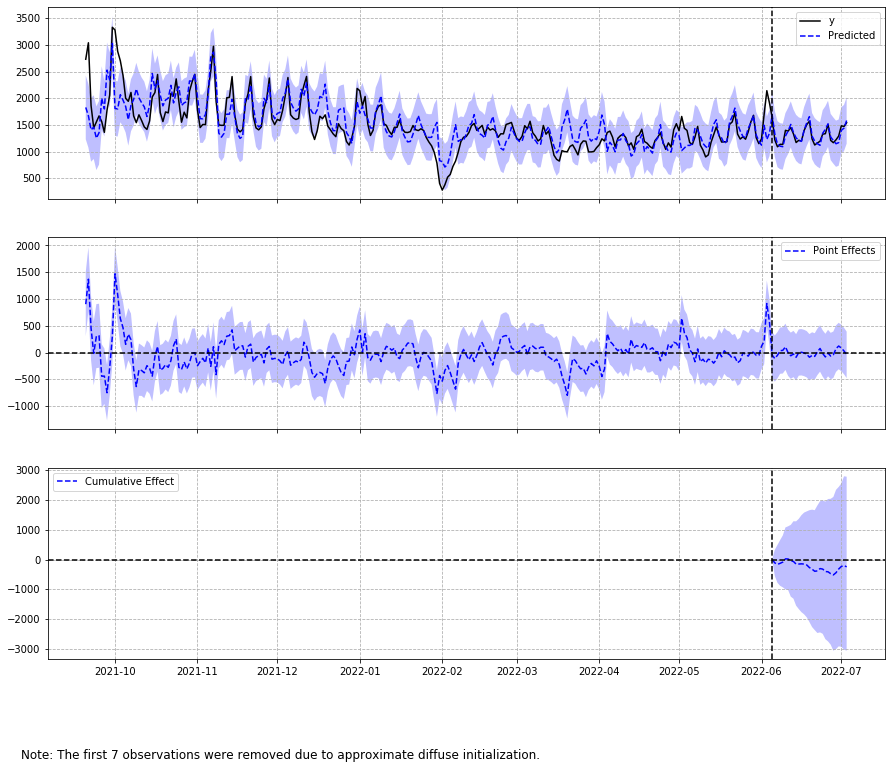

In [11]:
# 对照期结束时间
time_point_1='2022-06-05'
## AA检验期开始时间
time_point_2='2022-06-06'

busi_type='市内'
treat_label='降价'
contrl_province=['对照组']
response_feature='完单'    ##  gmv，毛利
##covariate_list  暂不自定义筛选，先手动筛选看效果

## AA对照测试/评估逻辑与AA对照一致
print(busi_type,'-',treat_label,'-',response_feature,'   评估')
data_clear_1=data_clear(data,busi_type=busi_type,treat_label=treat_label,contrl_province=contrl_province,response_feature=response_feature)
ci=CI(data_clear_1,time_point_1,time_point_2)

跨城 - 涨价 - 完单    评估


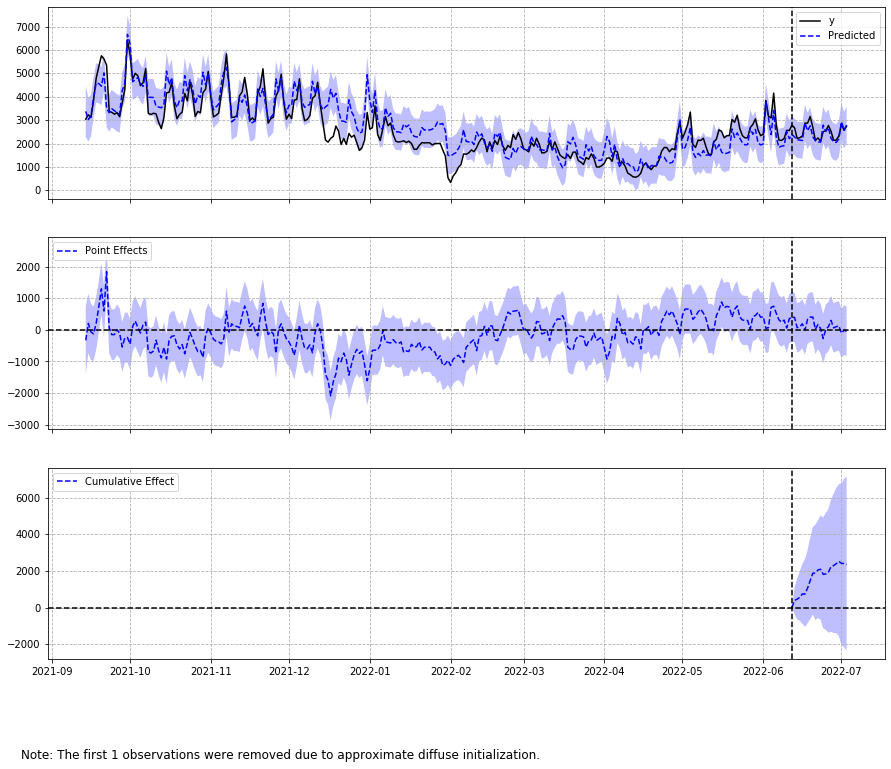

In [14]:
# 对照期结束时间
time_point_1='2022-06-12'
## AA检验期开始时间
time_point_2='2022-06-13'

busi_type='跨城'
treat_label='涨价'
contrl_province=['对照组']
response_feature='完单'    ##  gmv，毛利
##covariate_list  暂不自定义筛选，先手动筛选看效果

## AA对照测试/评估逻辑与AA对照一致
print(busi_type,'-',treat_label,'-',response_feature,'   评估')
data_clear_1=data_clear(data,busi_type=busi_type,treat_label=treat_label,contrl_province=contrl_province,response_feature=response_feature)
ci=CI(data_clear_1,time_point_1,time_point_2)

跨城 - 降价 - 完单    评估


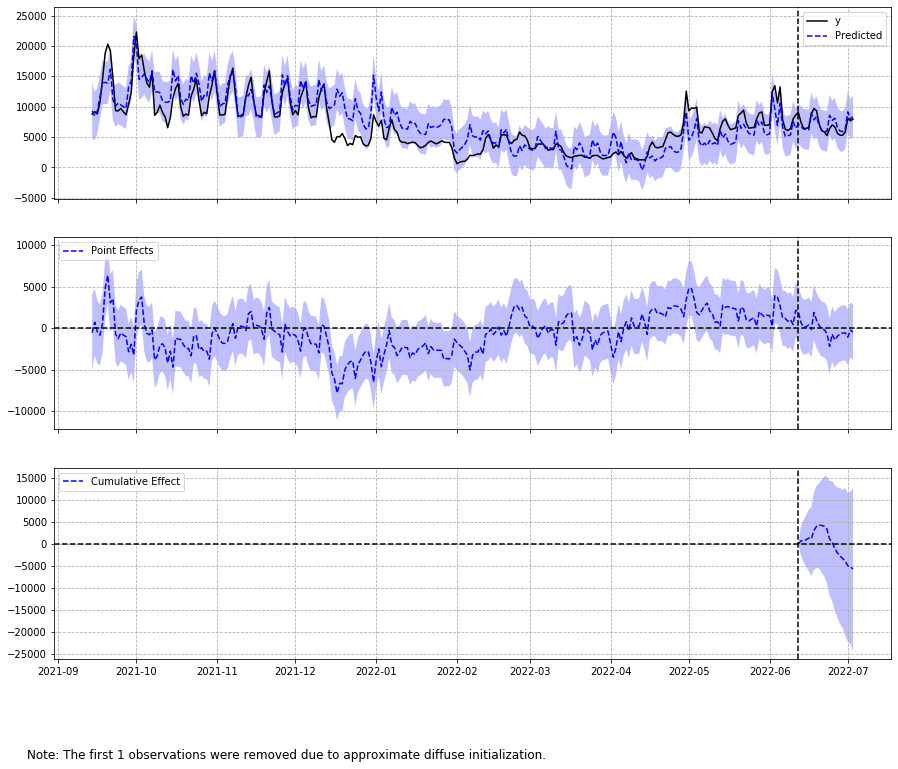

In [15]:
# 对照期结束时间
time_point_1='2022-06-12'
## AA检验期开始时间
time_point_2='2022-06-13'

busi_type='跨城'
treat_label='降价'
contrl_province=['对照组']
response_feature='完单'    ##  gmv，毛利
##covariate_list  暂不自定义筛选，先手动筛选看效果

## AA对照测试/评估逻辑与AA对照一致
print(busi_type,'-',treat_label,'-',response_feature,'   评估')
data_clear_1=data_clear(data,busi_type=busi_type,treat_label=treat_label,contrl_province=contrl_province,response_feature=response_feature)
ci=CI(data_clear_1,time_point_1,time_point_2)